In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
from IPython import display

import rhinoinside
rhinoinside.load()
import Rhino.Geometry as rg
import Rhino

from userstrings.userstring_utility import load_with_us, filter_by_userstring

import matplotlib.pyplot as plt
import vapeplot
from pathlib import Path

In [222]:
location = "Seattle"
objs = load_with_us('..//Cities//{location}.3dm'.format(location = location))

In [223]:
def normalize(a, axis=-1, order=2):
        l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
        l2[l2==0] = 1
        return a / np.expand_dims(l2, axis)[0]

In [224]:
#projects a triangle and AABB onto one axis to see if they overlap
#origin is an array of X,Y,Z coordinates, uvw is an array of u,v,w dimensions

def IntersectsSat(v0, v1, v2, uvw, axis):
    p0 = np.dot(v0, axis)
    p1 = np.dot(v1, axis)
    p2 = np.dot(v2, axis)


    #length of the projection onto an axis, assume bounding_box is at the origin
    r = uvw[0] * abs(np.dot((1, 0, 0), axis)) + uvw[1]* abs(np.dot((0, 1, 0), axis)) + uvw[2] * abs(np.dot((0, 0, 1), axis)) 

    #min and max points of the projected triangle to create a line from minP to maxP
    maxP = max(p0, p1, p2)
    minP = min(p0, p1, p2)

    #returns whether the line 0 to r overlaps with the line minP to maxP
    return max(-maxP, minP) <= r

In [225]:
# tri is a Triangle object, bounding_box is an axis-aligned bounding box
# once one evaluation doesn't intersect we return false

def IntersectsTriangleBounding_box (v0, v1, v2, vox_origin, uvw):

    center = [vox_origin[0], vox_origin[1], vox_origin[2]]
    
    tri_a = [v0[0] - center[0], v0[1]-center[1], v0[2]-center[2]]
    tri_b = [v1[0] - center[0], v1[1]-center[1], v1[2]-center[2]]
    tri_c = [v2[0] - center[0], v2[1]-center[1], v2[2]-center[2]]
    
    ab = normalize([tri_b[0] - tri_a[0], tri_b[1]-tri_a[1], tri_b[2]-tri_a[2]])
    bc = normalize([tri_c[0] - tri_b[0], tri_c[1]-tri_b[1], tri_c[2]-tri_b[2]])
    ca = normalize([tri_a[0] - tri_c[0], tri_a[1]-tri_c[1], tri_a[2]-tri_c[2]])

    # Cross ab, bc, and ca with (1, 0, 0)
    a00 = np.cross(ab, [1,0,0])
    a01 = np.cross(bc, [1,0,0])
    a02 = np.cross(ca, [1,0,0])

    # Cross ab, bc, and ca with (0, 1, 0)
    a10 = np.cross(ab, [0,1,0])
    a11 = np.cross(bc, [0,1,0])
    a12 = np.cross(ca, [0,1,0])

    # Cross ab, bc, and ca with (0, 0, 1)
    a20 = np.cross(ab, [0,0,1])
    a21 = np.cross(bc, [0,0,1])
    a22 = np.cross(ca, [0,0,1])

    if (not IntersectsSat(tri_a, tri_b, tri_c, uvw, a00) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, a01) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, a02) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, a10) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, a11) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, a12) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, a20) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, a21) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, a22) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, (1, 0, 0)) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, (0, 1, 0)) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, (0, 0, 1)) or
    not IntersectsSat(tri_a, tri_b, tri_c, uvw, np.cross(ab, bc))):

        return False

    return True


In [226]:
# Unit tests

vox_origin_0 = [0, 0, 0]
vox_origin_1 = [4, 4, 0]
uvw = [1, 1, 1]

print(IntersectsTriangleBounding_box([.25, .5, .5], [.5, .75, .5], [.75, .5, .5], vox_origin_0, uvw))   # case 0
print(IntersectsTriangleBounding_box([-1, 0, .5], [.5, 2, .5], [5.5, -3, .5], vox_origin_0, uvw))       # case 1
print(IntersectsTriangleBounding_box([2, 2, .5], [2.5, 3, .5], [3, 2, .5], vox_origin_0, uvw))          # case 2
print(IntersectsTriangleBounding_box([4.5, 4.5, .5], [5, 3.5, .5], [5.5, 4.5, .5], vox_origin_0, uvw))  # case 3
print(IntersectsTriangleBounding_box([.25, .5, .5], [.5, .75, .5], [.75, .5, .5], vox_origin_1, uvw))   # case 0
print(IntersectsTriangleBounding_box([-1, 0, .5], [.5, 2, .5], [5.5, -3, .5], vox_origin_1, uvw))       # case 1
print(IntersectsTriangleBounding_box([2, 2, .5], [2.5, 3, .5], [3, 2, .5], vox_origin_1, uvw))          # case 2
print(IntersectsTriangleBounding_box([4.5, 4.5, .5], [5, 3.5, .5], [5.5, 4.5, .5], vox_origin_1, uvw))  # case 3

True
True
False
False
False
False
False
True


In [227]:
# gets the vertices of a mesh face

def get_face_vertices(face, mesh_vertices):
    face_vertices = []
    v0 = mesh_vertices[face.A]
    v1 = mesh_vertices[face.B]
    v2 = mesh_vertices[face.C]

    face_vertices.append(np.array([v0.X, v0.Y, v0.Z]))
    face_vertices.append(np.array([v1.X, v1.Y, v1.Z]))
    face_vertices.append(np.array([v2.X, v2.Y, v2.Z]))

    return face_vertices

In [228]:
# makes a bounding box around all meshes

uvw = np.array([2, 2, 3.5])
min_val = np.array([math.inf, math.inf, math.inf])
max_val = np.array([-math.inf, -math.inf, -math.inf])
for meshes in objs:
    bbx = meshes.GetBoundingBox(True)
    if bbx.Max.X > max_val[0]:
        max_val[0] = bbx.Max.X
    if bbx.Max.Y > max_val[1]:
        max_val[1] = bbx.Max.Y
    if bbx.Max.Z > max_val[2]:
        max_val[2] = bbx.Max.Z
    if bbx.Min.X < min_val[0]:
        min_val[0] = bbx.Min.X
    if bbx.Min.Y < min_val[1]:
        min_val[1] = bbx.Min.Y
    if bbx.Min.Z < min_val[2]:
        min_val[2] = bbx.Min.Z

xyz = np.array([max_val[0] - min_val[0], max_val[1] - min_val[1], max_val[2] - min_val[2]])
t = np.array([min_val[0], min_val[1], min_val[2]])
vx_mask = np.zeros(shape = (xyz//uvw).astype(int) , dtype = np.int8)
vx_mask.shape

(413, 308, 55)

In [229]:
counter = 1

for mesh in objs:
    for a in range(len(mesh.get_Faces())):
        face = mesh.get_Faces()[a] # iterates through each face in the mesh
        vertices = np.array(get_face_vertices(face, mesh.get_Vertices())) # gets the vertices of the chosen face; it is an array [[x1, y1, z1], [x2, y2, z2], [x3, y3, z3]] 
        start = ((vertices.min(axis=0)-t)//uvw).astype(int)
        end = ((vertices.max(axis=0)-t)//uvw).astype(int)
        for i in range(start[0], end[0]):
            for j in range(start[1], end[1]):
                for k in range(start[2], end[2]):
                    origin = uvw * np.array([i,j,k]) + t
                    if IntersectsTriangleBounding_box(vertices[0], vertices[1], vertices[2], origin, uvw):
                        vx_mask[i,j,k] = 1
    if counter%100 == 0:
        display.clear_output()
    if counter%10 == 0:
        print(counter)
    counter += 1

300
310
320
330
340
350
360
370


In [ ]:
vertices = np.array(get_face_vertices(face, mesh.get_Vertices()))
(vertices.min(axis=0)-t)//uvw

array([326., 367.,  88.])

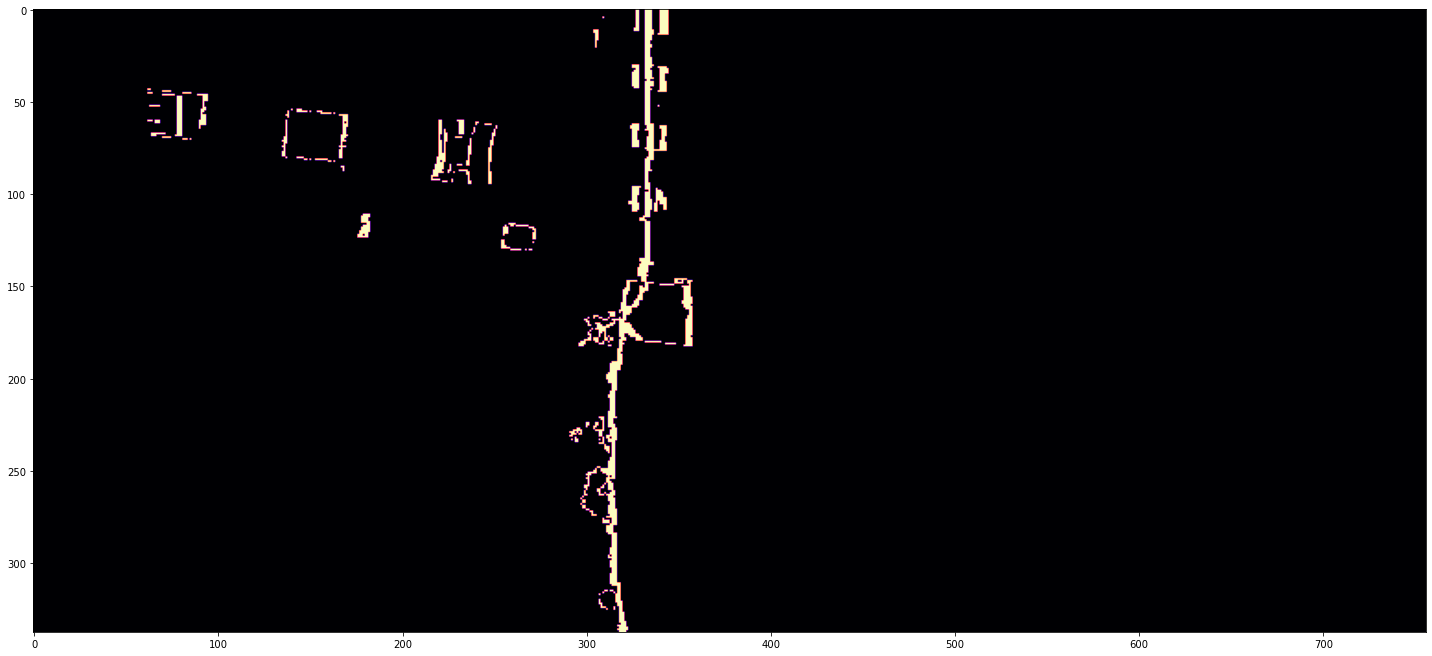

In [ ]:
z_level = 8

plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True

f = plt.imshow(vx_mask[:,:,z_level], origin = 'upper', cmap = 'magma')
f.figure.set_facecolor('white')
plt.show()

f.figure.savefig('./images/{location}_{z_level}.png'.format(location = location, z_level=z_level))

In [ ]:
import pickle

with open('./data/pickle_{location}'.format(location = location), 'wb') as f:
    pickle.dump(vx_mask, f)

In [ ]:
class Voxel_Lattice(object):
    def __init__(self, shape, uvw, parent=None, t=np.zeros(shape = (3,)), dtype=bool):
        self._vx_arr    = np.zeros(shape = shape).astype(dtype)
        self._uvw       = uvw
        self._t         = t
        self._parent    = parent

    def brep_mask(self, brep, val):
        for i in range(self._vx_arr.shape[0]):
            for j in range(self._vx_arr.shape[1]):
                for k in range(self._vx_arr.shape[2]):
                    p       = np.array([i+.5,j+.5,k+.5])*self._uvw+self._t
                    rh_p    = rg.Point3d(float(p[0]), float(p[1]), float(p[2]))

                    if brep.IsPointInside(rh_p, .01, True):
                        self._vx_arr[i,j,k]=val

    def points_to_voxel_mask(self, pts, val):
        ijks = (pts-self.t)//self._uvw
        self._vx_arr[ijks]=val

    @property
    def shape(self):
        return self._vx_arr.shape

    @property
    def area(self):
        area = np.sum(self._vx_arr)*self.uvw[0]*self.uvw[1]
        return area

    @property
    def volume(self):
        volume = np.sum(self._vx_arr)*self.uvw[0]*self.uvw[1]*self.uvw[2]
        return volume

In [ ]:
objs = load_with_us('.3dm//test_brep_control.3dm')

ctrl_brps = filter_by_userstring(objs, ['type'], ['brep_control'])

In [ ]:
vl = Voxel_Lattice(shape=(14,14,4), uvw=np.array([2,2,3.5]))
test_br = ctrl_brps[0]

vl.brep_mask(test_br, True)


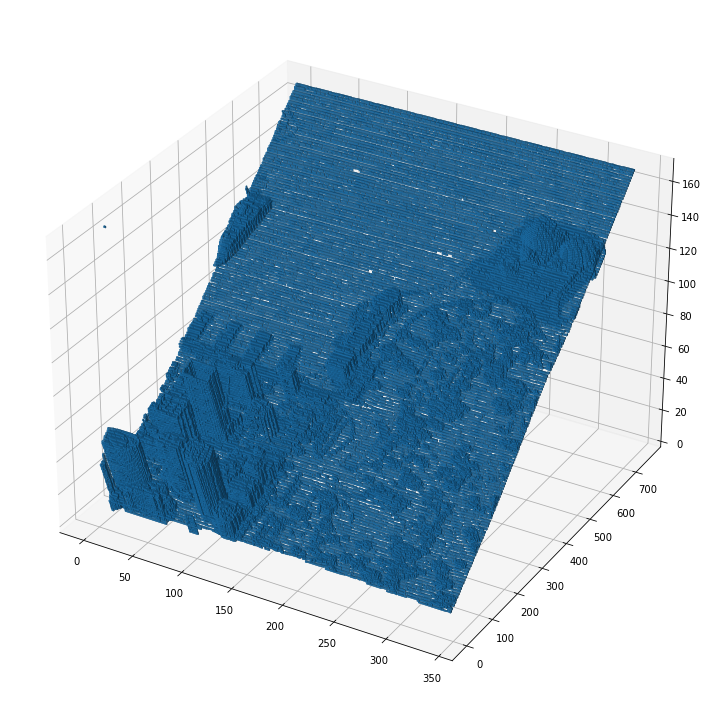

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.voxels(vx_mask)

plt.show()

ax.figure.savefig('./images/voxelization_{0}'.format(location))